# Lab 03: Transformers and Paragraphs

### What You Will Learn

- The fundamental reasons why the Transformer is such
a powerful and popular architecure
- Core intuitions for the behavior of Transformer architectures
- How to use a convolutional encoder and a Transformer decoder to recognize
entire paragraphs of text

## Setup

In [1]:
if "bootstrap" not in locals() or bootstrap.run:
    # path management for Python
    pythonpath, = !echo $PYTHONPATH
    if "." not in pythonpath.split(":"):
        pythonpath = ".:" + pythonpath
        %env PYTHONPATH={pythonpath}
        !echo $PYTHONPATH

    # get both Colab and local notebooks into the same state
    !wget --quiet https://fsdl.me/gist-bootstrap -O bootstrap.py
    import bootstrap

    # change into the lab directory
    # bootstrap.change_to_lab_dir(lab_idx=lab_idx)

    # allow "hot-reloading" of modules
    %load_ext autoreload
    %autoreload 2
    # needed for inline plots in some contexts
    %matplotlib inline

    bootstrap.run = False  # change to True re-run setup
    
!pwd
%ls

/home/amazingguni/git/fsdl-text-recognizer-2022-labs
Makefile   data/            lightning_logs/  requirements/     training/
README.md  environment.yml  notebooks/       text_recognizer/


In [2]:
from IPython import display

base_url = "https://fsdl-public-assets.s3.us-west-2.amazonaws.com"

display.Image(url=base_url + "/aiayn-figure-1.png")

In [3]:
from text_recognizer.models import ResnetTransformer


ResnetTransformer.forward??

Signature: ResnetTransformer.forward(self, x: torch.Tensor) -> torch.Tensor
Source:   
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Autoregressively produce sequences of labels from input images.

        Parameters
        ----------
        x
            (B, Ch, H, W) image, where Ch == 1 or Ch == 3

        Returns
        -------
        output_tokens
            (B, Sy) with elements in [0, C-1] where C is num_classes
        """
        B = x.shape[0]
        S = self.max_output_length
        x = self.encode(x)  # (Sx, B, E)

        output_tokens = (torch.ones((B, S)) * self.padding_token).type_as(x).long()  # (B, Sy)
        output_tokens[:, 0] = self.start_token  # Set start token
        for Sy in range(1, S):
            y = output_tokens[:, :Sy]  # (B, Sy)
            output = self.decode(x, y)  # (Sy, B, C)
            output = torch.argmax(output, dim=-1)  # (Sy, B)
            output_tokens[:, Sy] = output[-1]  # Set the last output token

        

In [4]:
from text_recognizer.lit_models import TransformerLitModel

TransformerLitModel.training_step??

Signature: TransformerLitModel.training_step(self, batch, batch_idx)
Docstring:
Here you compute and return the training loss and some additional metrics for e.g.
the progress bar or logger.

Args:
    batch (:class:`~torch.Tensor` | (:class:`~torch.Tensor`, ...) | [:class:`~torch.Tensor`, ...]):
        The output of your :class:`~torch.utils.data.DataLoader`. A tensor, tuple or list.
    batch_idx (``int``): Integer displaying index of this batch
    optimizer_idx (``int``): When using multiple optimizers, this argument will also be present.
    hiddens (``Any``): Passed in if
        :paramref:`~pytorch_lightning.core.lightning.LightningModule.truncated_bptt_steps` > 0.

Return:
    Any of.

    - :class:`~torch.Tensor` - The loss tensor
    - ``dict`` - A dictionary. Can include any keys, but must include the key ``'loss'``
    - ``None`` - Training will skip to the next batch. This is only for automatic optimization.
        This is not supported for multi-GPU, TPU, IPU, or DeepSp

In [5]:
TransformerLitModel.teacher_forward??

Signature: TransformerLitModel.teacher_forward(self, x: torch.Tensor, y: torch.Tensor) -> torch.Tensor
Source:   
    def teacher_forward(self, x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        """Uses provided sequence y as guide for non-autoregressive encoding-decoding of x.

        Parameters
        ----------
        x
            Batch of images to be encoded. See self.model.encode for shape information.
        y
            Batch of ground truth output sequences.

        Returns
        -------
        torch.Tensor
            (B, C, Sy) logits
        """
        x = self.model.encode(x)
        output = self.model.decode(x, y)  # (Sy, B, C)
        return output.permute(1, 2, 0)  # (B, C, Sy)
File:      ~/git/fsdl-text-recognizer-2022-labs/text_recognizer/lit_models/transformer.py
Type:      function


### Intuition #1: Transformers are highly residual.

In [6]:
display.Image(url=base_url + "/transformer-residual-view.png")

### Intuition #2 Transformer heads learn low rank transformations.

In [7]:
display.Latex(r"$\text{softmax}(Q \cdot K^T) \cdot V$")

<IPython.core.display.Latex object>

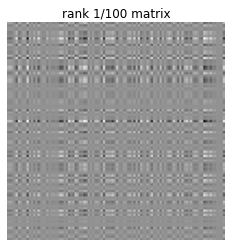

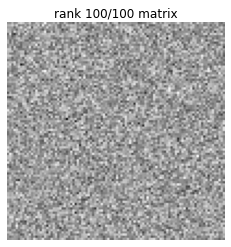

In [8]:
import matplotlib.pyplot as plt
import torch


low_rank = torch.randn(100, 1) @ torch.randn(1, 100)
full_rank = torch.randn(100, 100)
plt.figure(); plt.title("rank 1/100 matrix"); plt.imshow(low_rank, cmap="Greys"); plt.axis("off")
plt.figure(); plt.title("rank 100/100 matrix");  plt.imshow(full_rank, cmap="Greys"); plt.axis("off");

### Residuality and low rank together make Transformers less like a sequence model and more like a computer (that we can take gradients through).

In [9]:
display.Image(url=base_url + "/transformer-layer-residual.png")

In [10]:
display.Image(url=base_url + "/residual-stream-read-write.png")

In [11]:
display.Image(url=base_url + "/residual-token-to-token.png")

### Implementation detail: Transformers are position-insensitive by default.

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [-inf, 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [-inf, -inf, 0., 0., 0., 0., 0., 0., 0., 0.],
        [-inf, -inf, -inf, 0., 0., 0., 0., 0., 0., 0.],
        [-inf, -inf, -inf, -inf, 0., 0., 0., 0., 0., 0.],
        [-inf, -inf, -inf, -inf, -inf, 0., 0., 0., 0., 0.],
        [-inf, -inf, -inf, -inf, -inf, -inf, 0., 0., 0., 0.],
        [-inf, -inf, -inf, -inf, -inf, -inf, -inf, 0., 0., 0.],
        [-inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, 0., 0.],
        [-inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, 0.]])


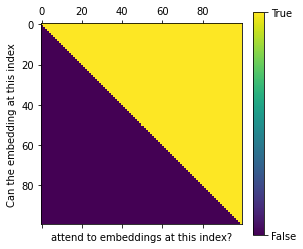

In [12]:
from text_recognizer.models import transformer_util


attention_mask = transformer_util.generate_square_subsequent_mask(100)

ax = plt.matshow(torch.exp(attention_mask.T));  cb = plt.colorbar(ticks=[0, 1], fraction=0.05)
plt.ylabel("Can the embedding at this index"); plt.xlabel("attend to embeddings at this index?")
print(attention_mask[:10, :10].T); cb.set_ticklabels([False, True]);

tensor([[ 0.0000,  0.8415,  0.9093,  0.1411, -0.7568, -0.9589, -0.2794,  0.6570],
        [ 1.0000,  0.5403, -0.4161, -0.9900, -0.6536,  0.2837,  0.9602,  0.7539],
        [ 0.0000,  0.6379,  0.9825,  0.8753,  0.3656, -0.3123, -0.8465, -0.9915],
        [ 1.0000,  0.7701,  0.1860, -0.4835, -0.9308, -0.9500, -0.5324,  0.1301]])


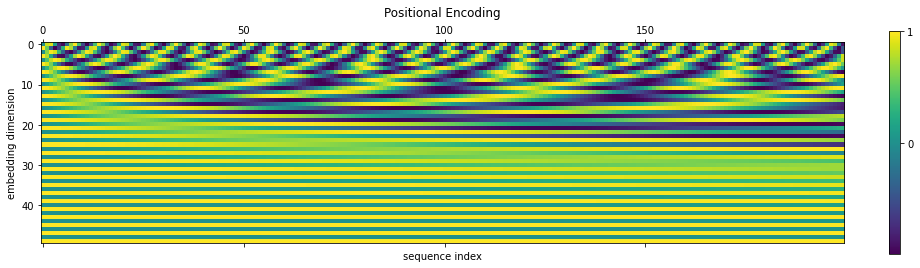

In [13]:
PositionalEncoder = transformer_util.PositionalEncoding(d_model=50, dropout=0.0, max_len=200)

pe = PositionalEncoder.pe.squeeze().T[:, :]  # placing sequence dimension along the "x-axis"

ax = plt.matshow(pe); plt.colorbar(ticks=[-1, 0, 1], fraction=0.05)
plt.xlabel("sequence index"); plt.ylabel("embedding dimension"); plt.title("Positional Encoding", y=1.1)
print(pe[:4, :8])

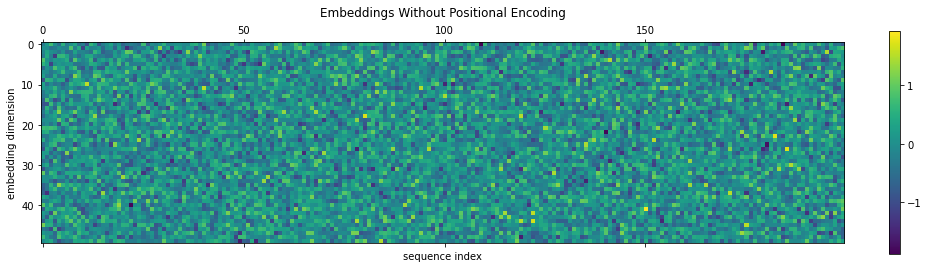

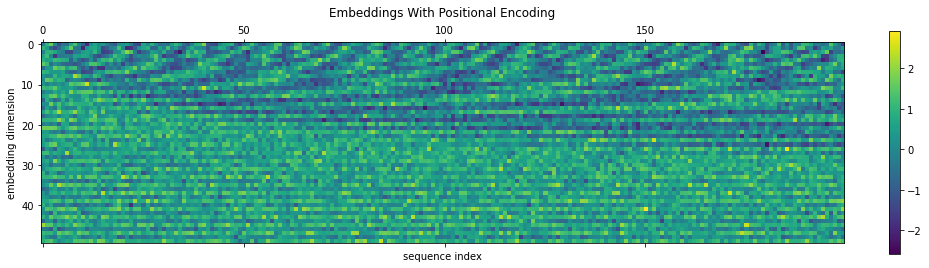

In [14]:
fake_embeddings = torch.randn_like(pe) * 0.5

ax = plt.matshow(fake_embeddings); plt.colorbar(ticks=torch.arange(-2, 3), fraction=0.05)
plt.xlabel("sequence index"); plt.ylabel("embedding dimension"); plt.title("Embeddings Without Positional Encoding", y=1.1)

fake_embeddings_with_pe = fake_embeddings + pe

plt.matshow(fake_embeddings_with_pe); plt.colorbar(ticks=torch.arange(-2, 3), fraction=0.05)
plt.xlabel("sequence index"); plt.ylabel("embedding dimension"); plt.title("Embeddings With Positional Encoding", y=1.1);

# Using Transformers to read paragraphs of text

In [15]:
import text_recognizer.data


emnist_lines = text_recognizer.data.EMNISTLines()
line_cnn = text_recognizer.models.LineCNNSimple(emnist_lines.config())

# for sliding, see the for loop over range(S)
line_cnn.forward??

Signature: line_cnn.forward(x: torch.Tensor) -> torch.Tensor
Source:   
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Apply the LineCNN to an input image and return logits.

        Parameters
        ----------
        x
            (B, C, H, W) input image with H equal to IMAGE_SIZE

        Returns
        -------
        torch.Tensor
            (B, C, S) logits, where S is the length of the sequence and C is the number of classes
            S can be computed from W and CHAR_WIDTH
            C is self.num_classes
        """
        B, _C, H, W = x.shape
        assert H == IMAGE_SIZE  # Make sure we can use our CNN class

        # Compute number of windows
        S = math.floor((W - self.WW) / self.WS + 1)

        # NOTE: type_as properly sets device
        activations = torch.zeros((B, self.num_classes, S)).type_as(x)
        for s in range(S):
            start_w = self.WS * s
            end_w = start_w + self.WW
            window = x[:, :, :, start_

In [16]:
iam_paragraphs = text_recognizer.data.IAMParagraphs()

iam_paragraphs.prepare_data()
iam_paragraphs.setup()
xs, ys = next(iter(iam_paragraphs.val_dataloader()))

iam_paragraphs

IAMParagraphs.setup(None): Loading IAM paragraph regions and lines...


IAM Paragraphs Dataset
Num classes: 84
Input dims : (1, 576, 640)
Output dims: (682, 1)
Train/val/test sizes: 1087, 220, 232
Train Batch x stats: (torch.Size([128, 1, 576, 640]), torch.float32, tensor(0.), tensor(0.0241), tensor(0.0798), tensor(1.))
Train Batch y stats: (torch.Size([128, 682]), torch.int64, tensor(1), tensor(83))
Test Batch x stats: (torch.Size([128, 1, 576, 640]), torch.float32, tensor(0.), tensor(0.0278), tensor(0.0843), tensor(0.9373))
Test Batch y stats: (torch.Size([128, 682]), torch.int64, tensor(1), tensor(83))

<S>It was the battered and broken body of a woman.
He sent word straight away to near-by Merstham
Station, and a stretcher party took the body to
the Feathers Hotel to await identification.
Was it a case of suicide, where some unhappy soul
had walked deliberately into the blackness and
into the path of some train? This hardly seemed
likely, since, when she was examined by a local
doctor, the woman, young, small, and rather plump,
was found to have her own silk scarf drawn
almost tight enough to strangle her, and the ends
thrust in her mouth like a gag.<E>


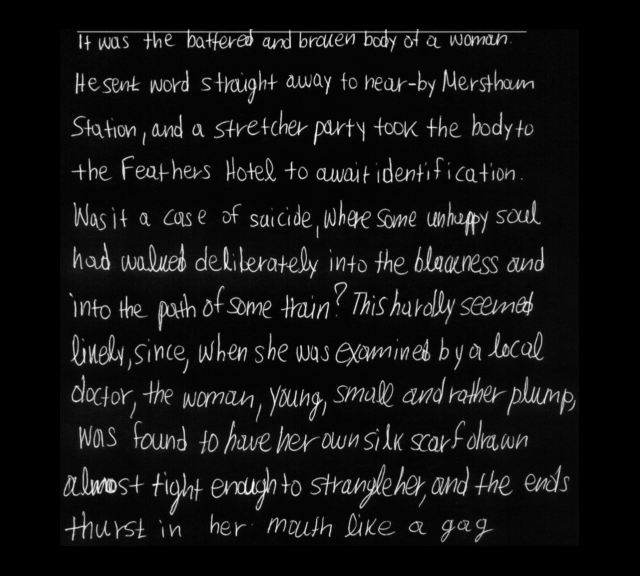

In [17]:
import random

import numpy as np
import wandb


def show(y):
    y = y.detach().cpu()  # bring back from accelerator if it's being used
    return "".join(np.array(iam_paragraphs.mapping)[y]).replace("<P>", "")

idx = random.randint(0, len(xs))

print(show(ys[idx]))
wandb.Image(xs[idx]).image

In [18]:
import text_recognizer.models


rnt = text_recognizer.models.ResnetTransformer(data_config=iam_paragraphs.config())

In [19]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

rnt.to(device); xs = xs.to(device); ys = ys.to(device);

In [20]:
resnet_embedding, = rnt.resnet(xs[idx:idx+1].repeat(1, 3, 1, 1))
 # resnet is designed for RGB images, so we replicate the input across channels 3 times

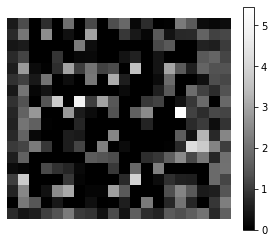

In [21]:
resnet_idx = random.randint(0, len(resnet_embedding))  # re-execute to view a different channel
plt.matshow(resnet_embedding[resnet_idx].detach().cpu(), cmap="Greys_r");
plt.axis("off"); plt.colorbar(fraction=0.05);

In [22]:
preds, = rnt(xs[idx:idx+1])  # can take up to two minutes on a CPU. Transformers ❤️ GPUs

<S>3NN3NN(33WNn33N3NN3N3N4NNNN3NN3NN3NN(3N3NNN3N3NN3NNN33N(NNNZN(3N34333NN333NNNN3NSN3VNN3N(N(N3NNN43N3VN3(3NEN33(33N(N333N33ENN3N4N3N33333N3NN3N6N3NENN33N3NN3NN333VN33NV3CNN3N(NN333N(3N3NNNVNN333NN3N(33NNNN(NNN3(NNNA3N33N3N33NNL34NNN(N3NN3NV33N333NVNN3NN3N3NN3NNNN3N3NN3N3NN3N336E333NNV333NNNNNN33NV3N3333NNN3NN333N3N(3NN33N693N3VN3N3NVNV3N3334N((N333N33N(VSNN4C3333N3N3N3N33N3333C3N3NE34NEN3N3N3N33N3NN3N3N3NE333NNNNL3N33NVN34CN3NV3N933NNN333NNN3N3NNN3E33NN3NNN3NNN3NN(NNNN3NNN33N3NV3NW3333NN34NNN33(3N33NN4N3V3NNN3N(N34N(33(VW3N33N3N33CN33N3(N333N33(N33(N3N33N33NZN3333N3C(N4N(3N3NN3NNNN3N3(3N3N3NNN3N3N333333VN33NN3NN3N3NWN46C(N3N(3NNN3N33NN(N3N33N3NNN3NN33NN(N(N3333N33333N3NN33N


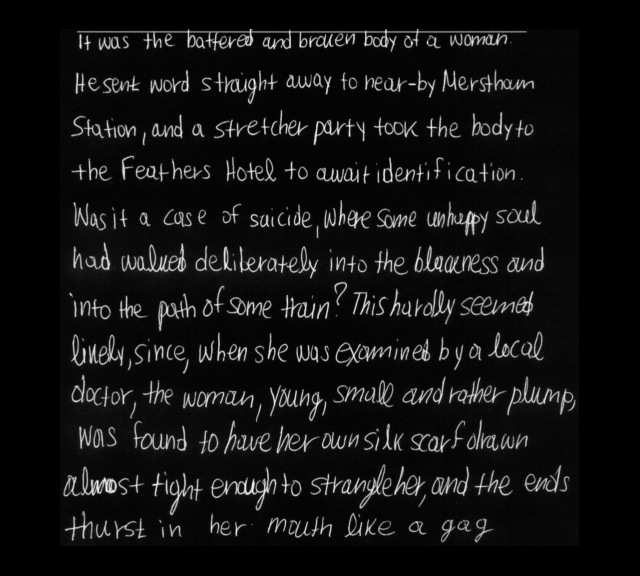

In [23]:
print(show(preds.cpu()))
wandb.Image(xs[idx]).image

In [24]:
import text_recognizer.lit_models

lit_rnt = text_recognizer.lit_models.TransformerLitModel(rnt)

In [25]:
forcing_outs, = lit_rnt.teacher_forward(xs[idx:idx+1], ys[idx:idx+1])

33N33NN33N333NEN3333N33N3WNN3NNNNN(33NN3NNNN3333NE333333N33333333NN334333.3N4(3333ZNV43NN3NN383N33N3NN3NNN333(N3N3334N3N33((N(333N33N33343N33NNE3NN3N3E63(NN3N3NNNNN3N3N63N333(3N433CNaN33NNN3333N3333N3(3N33N3N3N3333VN3(A3WNV33N3VNNNN33N(V33(NVC33N3N3333NN33VNVNEN3N3N3(3N33NN33N33NNN33N3333333N333N3NNE33333NC3N3NN3333N3333NCNNN3N33N33(3333(3(N3N3N333WN3N3333333NNN3(33(3NN33N333N3333VN3N333NN33(N3NN3(N33N3N3N(N333N333NNNGN33333NN3NN3E3(3333NNNNNNNNNN3NN3333NN3NN3N3NN3NN33N33N33ENN3NNN3333N3333(N33NNNEN3N3N3NNN3CN3NN33333NN33NNNN3N33N3NN3N3NN33(33NN3N33NN33NN333N33N3N43N6NN3N3N3NN33E3NN333N3333(3N333333(333N33333N33N336333NE33N6N3E33333N33333333N33N33N3NN3N3NEN33NN34N33NNN3NN33


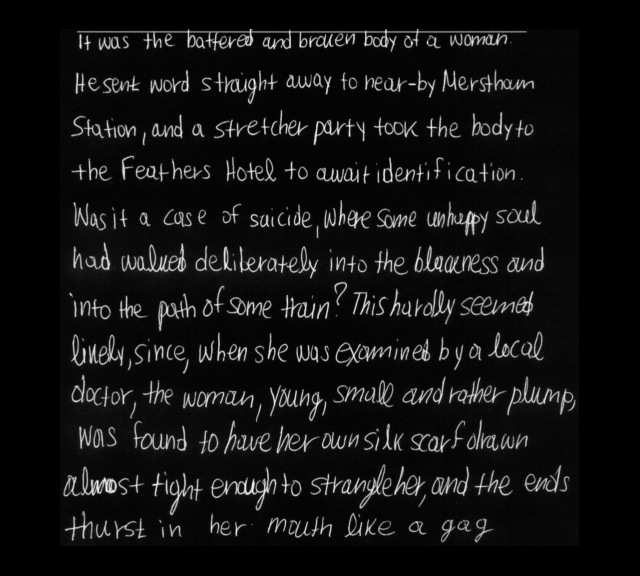

In [26]:
forcing_preds = torch.argmax(forcing_outs, dim=0)

print(show(forcing_preds.cpu()))
wandb.Image(xs[idx]).image

## Training the `ResNetTransformer`

In [27]:
import torch

gpus = int(torch.cuda.is_available())

if gpus:
    !nvidia-smi
else:
    print("watch out! working with this model on a typical CPU is not feasible")

Wed Jan 25 20:22:58 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.60.12    Driver Version: 527.41       CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:01:00.0  On |                  N/A |
| 30%   48C    P2    70W / 200W |   4395MiB /  8192MiB |      7%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [28]:
%%time
# above %%magic times the cell, useful as a poor man's profiler

%run training/run_experiment.py --data_class IAMParagraphs --model_class ResnetTransformer --loss transformer \
  --gpus={gpus} --batch_size 4 --precision 16 \
  --limit_train_batches 10 --limit_test_batches 1 --limit_val_batches 2

Using 16bit native Automatic Mixed Precision (AMP)
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_test_batches=1)` was configured so 1 batch will be used.
IAMParagraphs.setup(fit): Loading IAM paragraph regions and lines...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                      | Type                    | Params
-----------------------------------------------------------------------
0  | model                     | ResnetTransformer       | 14.0 M
1  | model.resnet              | Sequential              | 11.2 M
2  | model.encoder_projection  | Conv2d                  | 131 K 
3  | model.enc_pos_encoder     | PositionalEncodingImage | 0     
4  | model.embedding           | Embeddin

Model State Dict Disk Size: 56.06 MB


Sanity Checking: 0it [00:00, ?it/s]

/home/amazingguni/miniconda3/envs/fsdl-text-recognizer-2022/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1927: PossibleUserWarning: The number of training batches (10) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Best model saved at: /home/amazingguni/git/fsdl-text-recognizer-2022-labs/training/logs/lightning_logs/version_10/epoch=0000-validation.loss=3.403-validation.cer=1.747.ckpt
IAMParagraphs.setup(test): Loading IAM paragraph regions and lines...
Restoring states from the checkpoint path at /home/amazingguni/git/fsdl-text-recognizer-2022-labs/training/logs/lightning_logs/version_10/epoch=0000-validation.loss=3.403-validation.cer=1.747.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /home/amazingguni/git/fsdl-text-recognizer-2022-labs/training/logs/lightning_logs/version_10/epoch=0000-validation.loss=3.403-validation.cer=1.747.ckpt


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test/cer             1.865925908088684
        test/loss           3.1798794269561768
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
CPU times: user 2min 21s, sys: 6.85 s, total: 2min 28s
Wall time: 48.3 s


<Figure size 432x288 with 0 Axes>